<a href="https://colab.research.google.com/github/jdmartinev/ST1613-AppliedML-/blob/main/Taller%201/Regresi%C3%B3n_con_RF_y_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1: Regresión con Random Forest y Gradient Boosting


En este taller se aplicará ensambes de árboles de decisión tipo random forest y gradient boosting a un conjunto de datos de jugadores del video juego FIFA 19. Los datos utilizados son un subconjunto modificado de [este set de datos](https://www.kaggle.com/karangadiya/fifa19) y se encuentran en el archivo `FIFA 19 players.csv`. La tarea a realizar consiste en predecir el salario (wage) de los jugadores.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    #BinaryEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [2]:
#Obtenemos los datos
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE' -O players.csv

#Obtenemos los datos
import urllib.request
url = "https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE"
urllib.request.urlretrieve(url, "players.csv")
print("Archivo descargado correctamente")

Archivo descargado correctamente


In [3]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [4]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [5]:
# Carguemos los datos:
data = pd.read_csv('players.csv')
data

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,L. Messi,31,94,565000,Left,5.0,4.0,4.0,90.0,90.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,Cristiano Ronaldo,33,94,405000,Right,5.0,4.0,5.0,94.0,94.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,Neymar Jr,26,92,290000,Right,5.0,5.0,5.0,87.0,87.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,K. De Bruyne,27,91,355000,Right,4.0,5.0,4.0,85.0,85.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,E. Hazard,27,91,340000,Right,4.0,4.0,4.0,86.0,86.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,1000,Right,1.0,2.0,2.0,44.0,44.0,...,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0
15922,N. Christoffersson,19,47,1000,Right,1.0,2.0,2.0,47.0,47.0,...,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0
15923,B. Worman,16,47,1000,Right,1.0,3.0,2.0,47.0,47.0,...,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0
15924,D. Walker-Rice,17,47,1000,Right,1.0,3.0,2.0,49.0,49.0,...,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0


In [6]:
# Veamos la descripción del dataset:
print('informacion general del dataset')
data.info()

print("\nEstadisticas descriptivas del dataser")
data.describe()

informacion general del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 63 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      15926 non-null  object 
 1   Age                       15926 non-null  int64  
 2   Overall                   15926 non-null  int64  
 3   Wage                      15926 non-null  int64  
 4   Preferred Foot            15926 non-null  object 
 5   International Reputation  15926 non-null  float64
 6   Weak Foot                 15926 non-null  float64
 7   Skill Moves               15926 non-null  float64
 8   LS                        15926 non-null  float64
 9   ST                        15926 non-null  float64
 10  RS                        15926 non-null  float64
 11  LW                        15926 non-null  float64
 12  LF                        15926 non-null  float64
 13  CF                        159

,Age,Overall,Wage,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,LW,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,...,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.00000,15926.000000,15926.000000,15926.000000
mean,24.991209,66.446189,10254.866256,1.116037,3.004081,2.533342,59.842647,59.842647,59.842647,61.066809,...,51.446126,59.575411,50.401168,54.844405,55.494726,52.118234,60.34654,51.273703,51.883021,49.593118
std,4.552866,6.809244,22692.769542,0.397762,0.636845,0.618186,9.141407,9.141407,9.141407,9.889102,...,15.718376,14.432944,18.797738,14.665434,12.897478,12.501841,10.14202,17.198926,19.161875,19.162508
min,16.000000,46.000000,1000.000000,1.000000,1.000000,2.000000,33.000000,33.000000,33.000000,27.000000,...,11.000000,13.000000,10.000000,11.000000,12.000000,12.000000,29.00000,10.000000,10.000000,10.000000
25%,21.000000,62.000000,1000.000000,1.000000,3.000000,2.000000,54.000000,54.000000,54.000000,55.000000,...,40.000000,50.000000,34.000000,46.000000,47.000000,42.000000,53.00000,37.000000,35.000000,32.000000
50%,25.000000,66.000000,3000.000000,1.000000,3.000000,2.000000,60.000000,60.000000,60.000000,62.000000,...,54.000000,61.000000,56.000000,57.000000,57.000000,52.000000,61.00000,56.000000,59.000000,56.000000
75%,28.000000,71.000000,10000.000000,1.000000,3.000000,3.000000,66.000000,66.000000,66.000000,68.000000,...,64.000000,70.000000,65.000000,65.000000,65.000000,61.000000,68.00000,65.000000,67.000000,65.000000
max,41.000000,94.000000,565000.000000,5.000000,5.000000,5.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.00000,94.000000,93.000000,91.000000


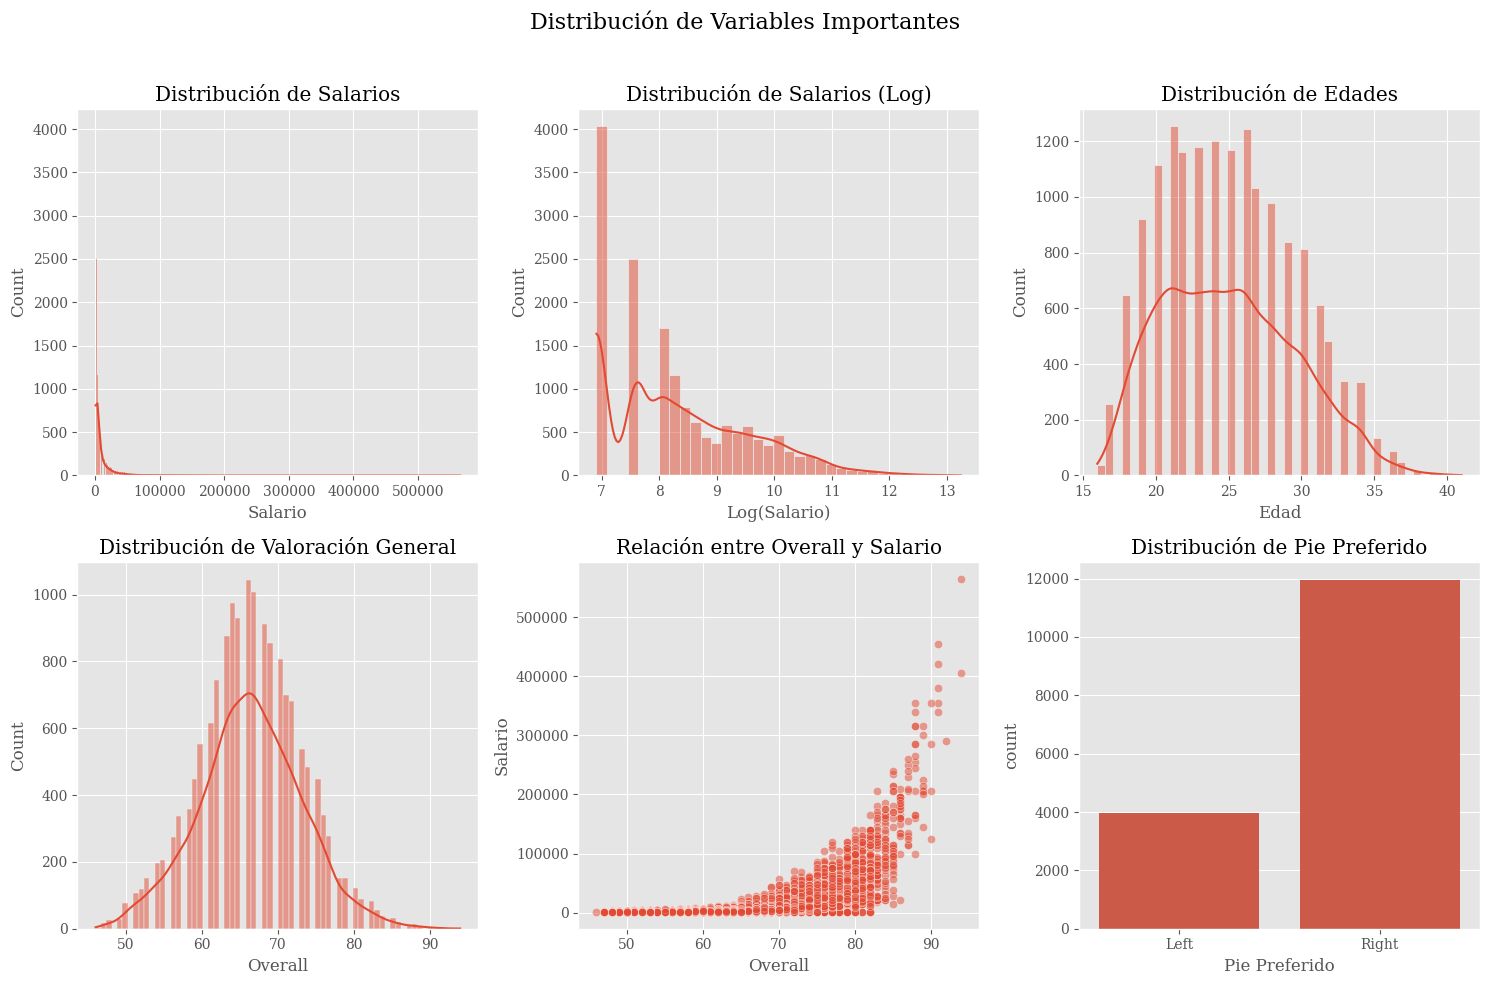

In [7]:
#Veamos la distribución de las columnas
# Configuramos el estilo de las gráficas
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

# Creamos una figura con varias subgráficas
fig, axes = plt.subplots(2, 3)
fig.suptitle('Distribución de Variables Importantes', fontsize=16)

# 1. Distribución del Salario (Wage) - nuestra variable objetivo
sns.histplot(data['Wage'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Salarios')
axes[0, 0].set_xlabel('Salario')

# 2. Distribución logarítmica del Salario (para ver mejor la distribución)
sns.histplot(np.log1p(data['Wage']), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Salarios (Log)')
axes[0, 1].set_xlabel('Log(Salario)')

# 3. Distribución de la Edad
sns.histplot(data['Age'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribución de Edades')
axes[0, 2].set_xlabel('Edad')

# 4. Distribución de Overall (Valoración General)
sns.histplot(data['Overall'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Valoración General')
axes[1, 0].set_xlabel('Overall')

# 5. Relación entre Overall y Wage
sns.scatterplot(x='Overall', y='Wage', data=data, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title('Relación entre Overall y Salario')
axes[1, 1].set_xlabel('Overall')
axes[1, 1].set_ylabel('Salario')

# 6. Distribución de Pie Preferido (categorical)
sns.countplot(x='Preferred Foot', data=data, ax=axes[1, 2])
axes[1, 2].set_title('Distribución de Pie Preferido')
axes[1, 2].set_xlabel('Pie Preferido')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta el espacio entre subgráficas
plt.show()

In [8]:
# Obtengamos la distribución de valores de la variable `Preferred Foot`:
# tip: pandas function value_counts()

pie_preferido = data['Preferred Foot'].value_counts()
print("Distribución de Pie Preferido:")
print(pie_preferido)

Distribución de Pie Preferido:
Preferred Foot
Right    11969
Left      3957
Name: count, dtype: int64


In [9]:
# Dado que esta columna es categorica, debemos incluir en el Pipeline su transformación. Utilizaremos 
# codificación binaria
#tip: scikit-learn BinaryEncoder -> Igual funcionamiento a OrdinalEncoder

# Creamos el encoder y definimos el orden de las categorias: Left=0, Right=1
encoder = OrdinalEncoder(categories=[['Left', 'Right']])

# Codificamos la columna y creamos una nueva con los valores transformados
data['Preferred_Foot_Encoded'] = encoder.fit_transform(data[['Preferred Foot']])

# Veamos los primeros registros para confirmar la codificación
print("Primeros registros con la columna codificada:")
print(data[['Preferred Foot', 'Preferred_Foot_Encoded']].head(10))

Primeros registros con la columna codificada:
  Preferred Foot  Preferred_Foot_Encoded
0           Left                     0.0
1          Right                     1.0
2          Right                     1.0
3          Right                     1.0
4          Right                     1.0
5          Right                     1.0
6          Right                     1.0
7          Right                     1.0
8          Right                     1.0
9          Right                     1.0


## Regresión

**Nota:** Dejaremos la coulmna `Name` en el datafrme para poder identificar a los jugadores, pero **la debemos excluir** al definir las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test`.

In [10]:
# Separemos los datos en conjuntos de entrenamiento (80 %) y prueba (20 %):

# Definimos las variables predictoras (X) y la variable objetivo (y)
# Excluimos 'Name' y 'Preferred Foot' (ya que tenemos 'Preferred_Foot_Encoded')
X = data.drop(['Name', 'Preferred Foot', 'Wage'], axis=1)
# Variable objetivo
y = data['Wage']

# Dividimos los daros en conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# verificamos las dimensiones de los conjuntos
print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}, {y_test.shape}")

Dimensiones del conjunto de entrenamiento: (12740, 61), (12740,)
Dimensiones del conjunto de prueba: (3186, 61), (3186,)


In [16]:
#Definimos las transformaciones
cat_cols = X_train.select_dtypes(include=object).columns
num_cols = X_train.select_dtypes(include=np.number).columns

categorical_transformer = 'passthrough'
numerical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ]
)

#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

#Definimos los pipelines
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_base)
])

pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', gb_base)
])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30]
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid, n_jobs=-1, verbose=2)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid, n_jobs=-1, verbose=2)

In [17]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: total: 9.55 s
Wall time: 2min 50s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         'passthrough',
                                                                         Index([], dtype='object')),
                                                                        ('num',
                                                                         'passthrough',
                                                                         Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'L...
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'Preferred_Foot_Encoded'],
      dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__n_estimators': [50, 100, 200]},
             verbose=2)

In [18]:
%%time
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: total: 13.9 s
Wall time: 4min 25s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         'passthrough',
                                                                         Index([], dtype='object')),
                                                                        ('num',
                                                                         'passthrough',
                                                                         Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'L...
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'Preferred_Foot_Encoded'],
      dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__n_estimators': [50, 100, 200]},
             verbose=2)

In [19]:
print(rf.best_params_)
print(gb.best_params_)

{'regressor__max_depth': 10, 'regressor__n_estimators': 50}
{'regressor__max_depth': 10, 'regressor__n_estimators': 50}


In [20]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')

Train set
Model: Random Forest
R^2: 0.9086607176954976
MAE: 3552.3535698670407


Model: Gradient Boosting
R^2: 0.9872450411331899
MAE: 1670.346686956025


Test set
Model: Random Forest
R^2: 0.8050829996005493
MAE: 4666.736238826522


Model: Gradient Boosting
R^2: 0.7690089052215467
MAE: 4828.218657164129




In [22]:
# Veamos los datos junto con las predicciones:
pd.concat([
    data.drop(columns='Wage').reset_index(drop=True),
    data['Wage'].reset_index(drop=True),
    pd.DataFrame({'rf_predicted_wage': rf.predict(data.drop(columns=['Name', 'Wage']))}),
    pd.DataFrame({'gb_predicted_wage': gb.predict(data.drop(columns=['Name', 'Wage']))})
], axis=1)

,Name,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Preferred_Foot_Encoded,Wage,rf_predicted_wage,gb_predicted_wage
0,L. Messi,31,94,Left,5.0,4.0,4.0,90.0,90.0,90.0,...,94.0,75.0,96.0,33.0,28.0,26.0,0.0,565000,337900.000000,333084.359602
1,Cristiano Ronaldo,33,94,Right,5.0,4.0,5.0,94.0,94.0,94.0,...,82.0,85.0,95.0,28.0,31.0,23.0,1.0,405000,387300.000000,402965.157670
2,Neymar Jr,26,92,Right,5.0,5.0,5.0,87.0,87.0,87.0,...,87.0,81.0,94.0,27.0,24.0,33.0,1.0,290000,308000.000000,288464.352955
3,K. De Bruyne,27,91,Right,4.0,5.0,4.0,85.0,85.0,85.0,...,94.0,79.0,88.0,68.0,58.0,51.0,1.0,355000,373400.000000,418420.033881
4,E. Hazard,27,91,Right,4.0,4.0,4.0,86.0,86.0,86.0,...,89.0,86.0,91.0,34.0,27.0,22.0,1.0,340000,327700.000000,338178.032110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,Right,1.0,2.0,2.0,44.0,44.0,44.0,...,52.0,43.0,45.0,40.0,48.0,47.0,1.0,1000,1060.416291,1173.355105
15922,N. Christoffersson,19,47,Right,1.0,2.0,2.0,47.0,47.0,47.0,...,33.0,43.0,42.0,22.0,15.0,19.0,1.0,1000,1135.707968,1280.475468
15923,B. Worman,16,47,Right,1.0,3.0,2.0,47.0,47.0,47.0,...,43.0,55.0,41.0,32.0,13.0,11.0,1.0,1000,1185.907000,1194.647434
15924,D. Walker-Rice,17,47,Right,1.0,3.0,2.0,49.0,49.0,49.0,...,47.0,50.0,46.0,20.0,25.0,27.0,1.0,1000,1060.416291,1203.031427


Explicabilidad

In [26]:
# !pip install shap
%pip install -q shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import shap
from IPython.display import HTML

In [28]:
# Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', 'passthrough',
                                                  Index([], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Cr...
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'Preferred_Foot_Encoded'],
      dtype='object'))])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=10, n_estimators=50,
                                           random_state=42))])

In [29]:
# Aplicamos el preproceso a los datos
X_train_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_test)

In [30]:
# Calculamos el valor esperado (linea base para las explicaciones)
y_est = pipeline_gb.predict(X_train)
Efx = np.mean(y_est)
print(f"Valor base (promedio de predicciones): {Efx}")

Valor base (promedio de predicciones): 10174.411302982731


In [31]:
# Entrenemos nuestro modelo de explicabilidad
gb_explainer = shap.TreeExplainer(pipeline_gb.named_steps['regressor'])
train_gb_shap_values = gb_explainer.shap_values(X_train_preprocessed)

In [32]:
# Verificacion de que los valores SHAP suman correctamente
val = train_gb_shap_values.sum(axis=1)
print("Primeros 5 valores de la suma de SHAP:", val[:5])

Primeros 5 valores de la suma de SHAP: [-8371.86984463  5779.06742464 -8425.72832326 -6469.99124127
  4090.41249257]


In [33]:
# Comparamos las predicciones originales con la suma de SHAP + valor base
fx = Efx + val
print("\nPrimeras 5 predicciones reconstruidas (Efx + SHAP):", fx[:5])


Primeras 5 predicciones reconstruidas (Efx + SHAP): [ 1802.54145835 15953.47872762  1748.68297972  3704.42006171
 14264.82379555]


In [34]:
# Las predicciones originales del modelo
y_est_check = pipeline_gb.predict(X_train)
print("\nPrimeras 5 predicciones originales:", y_est_check[:5])


Primeras 5 predicciones originales: [ 1802.54145835 15953.47872762  1748.68297972  3704.42006171
 14264.82379555]


In [35]:
# Verificamos que son iguales (dentro de un pequeño margen de error numerico)
print("\n¿Son iguales las predicciones? (Primeras 5):", np.allclose(fx[:5], y_est_check[:5], rtol=1e-5))


¿Son iguales las predicciones? (Primeras 5): True


In [36]:
# Verificamos las dimensiones de los arrays de valores SHAP
print(f"Forma de train_gb_shap_values: {train_gb_shap_values.shape}")

# Calculamos los valores SHAP para el conjunto de prueba
test_gb_shap_values = gb_explainer.shap_values(X_test_preprocessed)
print(f"Forma de test_gb_shap_values: {test_gb_shap_values.shape}")

Forma de train_gb_shap_values: (12740, 61)
Forma de test_gb_shap_values: (3186, 61)


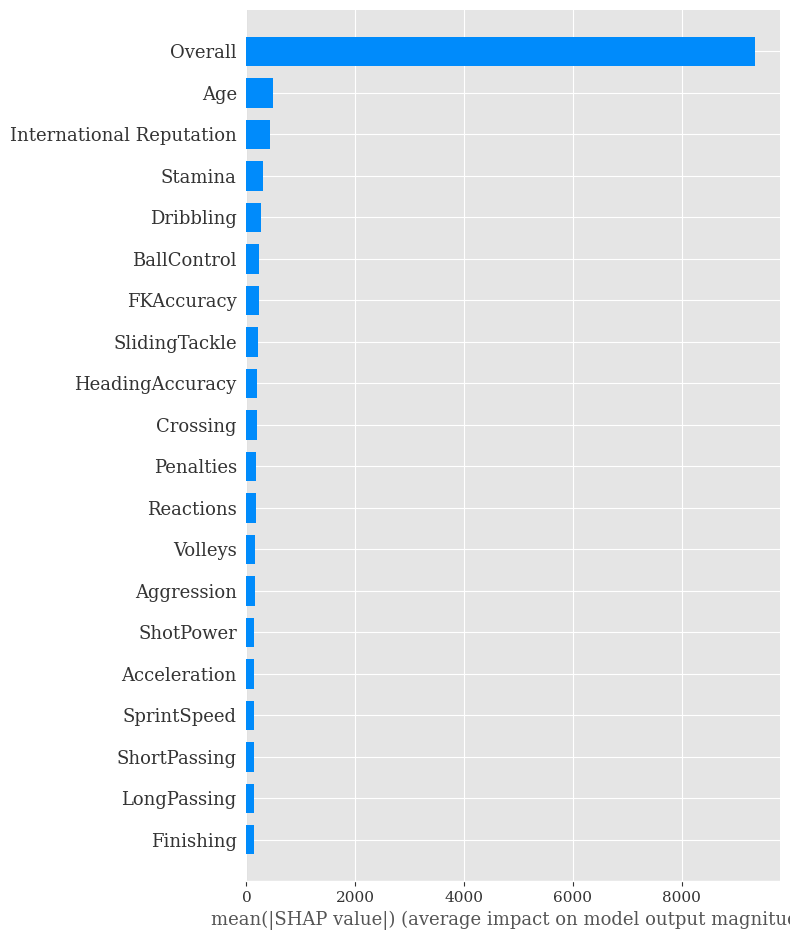

In [38]:
# Summary plot
shap.summary_plot(test_gb_shap_values, X_test, plot_type="bar")

Analizando al jugador: L. Messi (Overall: 94)


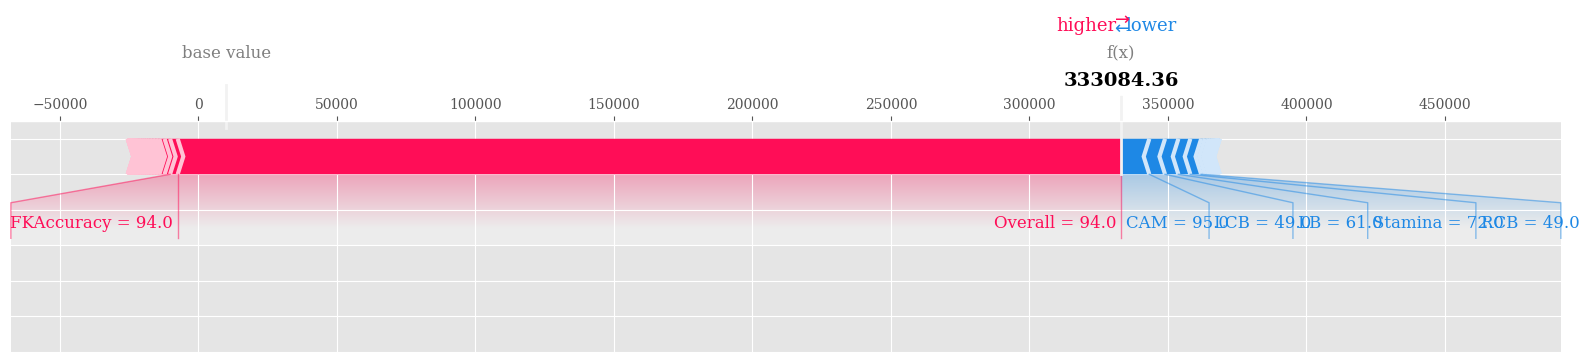

In [39]:
# Grafiquemos los valores SHAP para un ejemplo del conjunto de test
shap.initjs()

# Jugador con alto Overall
high_overall_index = X_test['Overall'].idxmax()
player_name = data.loc[high_overall_index, 'Name']
print(f"Analizando al jugador: {player_name} (Overall: {X_test.loc[high_overall_index, 'Overall']})")

shap.force_plot(gb_explainer.expected_value, 
                test_gb_shap_values[X_test.index.get_loc(high_overall_index)], 
                X_test.iloc[X_test.index.get_loc(high_overall_index)],
                matplotlib=True,
                show=True)

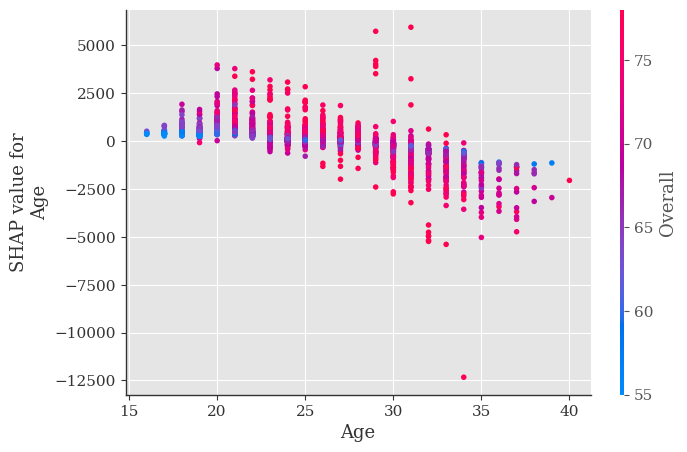

In [42]:
# Grafiquemos la dependencia de los valores SHAP con la variable "Age"
# shap.dependence_plot('Age', test_gb_shap_values, X_test, interaction_index=None, show=True)
shap.dependence_plot('Age', test_gb_shap_values, X_test)

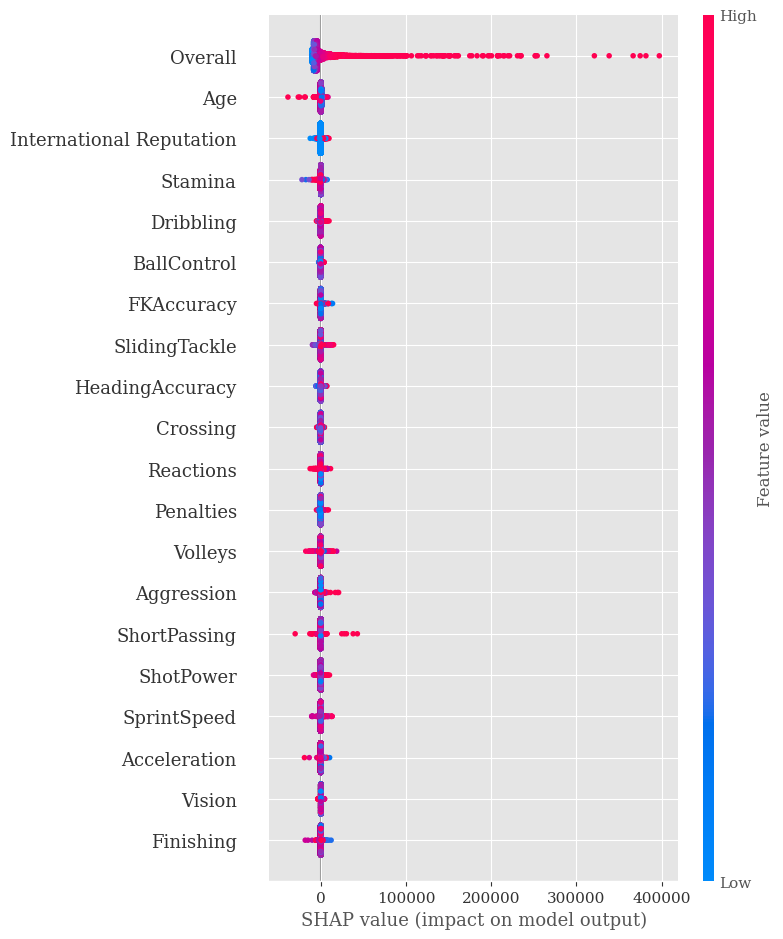

In [43]:
#Summary plot
shap.summary_plot(train_gb_shap_values, X_train)